# The Solow Model

Imports and set magics:

In [115]:
import numpy as np
from scipy import optimize
import sympy as sm
from sympy.solvers import solve
from sympy import *
sm.init_printing()
import matplotlib.pyplot as plt
from IPython.display import display, Math, Markdown

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**Solow model** 

Production function:
$$
Y_t = K_t^αH_t^σ(A_tL_t)^{(1-α-σ)}
$$

Y is output, K is physical capital, L is labor, H is human capital and A is technology. α and σ are the output elasticities of physical capital and human capital, respectively, and (1-α-σ) is the output elasticity of labor. 
Savings are divided in physical capital savings and human capital savings. They are defined as a constant fraction of the income. 
$$
S_t=(s_K+s_H)Y_t
$$

The accumulation of physical capital over time is defined as:
$$
K_{t+1} = s_KY_t + (1-δ)K_t
$$
where δ is the depreciation rate of capital, and $K_{t+1}$ and $K_t$ are the levels of physical capital in periods t+1 and t, respectively.

The accumulation of human capital over time is defined as:
$$
H_{t+1} = s_HY_t +(1-δ)H_t
$$
where δ is the depreciation rate of capital and $H_{t+1}$ and $H_t$ are the levels of human capital in periods t+1 and t, respectively.

Finally, the level of technology and labor are defined as:
$$
A_{t+1} = (1+g)A_t
$$
$$
L_{t+1} = (1+n)L_t
$$
where g is the rate of technological progress and n is the population growth. 

We define tilde-variables:
$$
\tilde{y}_{t}= \frac{Y_t}{A_tL_t}
$$
$$
\tilde{k}_{t}= \frac{K_t}{A_tL_t}
$$
$$
\tilde{h}_{t}= \frac{H_t}{A_tL_t}
$$
We define the transitions equation for physical capital and human capital as

$$
\begin{aligned}

    \tilde{k}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_K \tilde{k}_t^{\alpha} \tilde{h}_t^{σ} + (1-\delta) \tilde{k}_t),\\
    
    \tilde{h}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_H \tilde{h}_t^{\alpha} \tilde{h}_t^{σ} + (1-\delta) \tilde{h}_t).\\

\end{aligned}
$$


## Analytical solution

We begin by trying to solve the general Solow model analytically, and will expand with human capital later in the project. 

In [116]:
# Define the variables and parameters
k, L, s, delta, alpha, n, g = sm.symbols('k L s delta alpha n g')

# Define the production function
Y = k**alpha * L**(1-alpha)

# Define the savings and accumulation equations
S = s*Y
K_next = S + (1-delta)*k

# Define the labor accumulation equation
L_next = (1+n)*L

# Define the system of equations and solve for the steady state values
system = [Y - delta*k - K_next,
          S - K_next,
          L_next - L]

ss_sol = sm.solve(system, [k, L])

# Define the steady state function
k_ss = sm.lambdify((s, delta, alpha, n, g), ss_sol[0])

# Test the function with example parameters
params = (0.6, 0.05, 0.3, 0.01, 0.025)
print(k_ss(*params))

(0, 0)


Simpy solve on the Solow model was unsuccessful. This is because in the Solow model, the steady state values of k, L, and A are normally found by solving a system of nonlinear equations numerically, rather than analytically.

## Numerical solution

In [117]:
# Define the variables and parameters
k_tilde, h_tilde = sm.symbols('ktilde_t, htilde_t')
sK, sH, g, n, delta, alpha, sigma = sm.symbols('s_K, s_H, g, n, delta, alpha, sigma')

# Define the transition equations
k_trans = sm.Eq(k_tilde, 
                1/((1+n)*(1+g))*(sK*k_tilde**alpha*h_tilde**sigma+(1-delta)*k_tilde))
h_trans = sm.Eq(h_tilde, 
                1/((1+n)*(1+g))*(sH*k_tilde**alpha*h_tilde**sigma+(1-delta)*h_tilde))

# Derive nullclines from transition equations 
nullcline_k = sm.solve(k_trans,h_tilde)[0] 
null_k = sm.Eq(h_tilde, nullcline_k)

nullcline_h = sm.solve(h_trans,h_tilde)[0]
null_h = sm.Eq(h_tilde, nullcline_h)

# Use lambdify
null_k_func = sm.lambdify([k_tilde, alpha, delta, g, n, sigma, sK], nullcline_k)
null_h_func = sm.lambdify([k_tilde, alpha, delta, g, n, sigma, sH], nullcline_h)
 
# Define values 
k_tilde_vec = np.linspace(1,5000,100) 

alpha = 0.3
delta = 0.02
g = 0.02
n = 0.01
sigma = 0.5
sH = 0.2
sK = 0.3

null_k_val = null_k_func(k_tilde_vec,alpha,delta,g, n, sigma, sK)
null_h_val = null_h_func(k_tilde_vec,alpha,delta,g, n, sigma, sH)


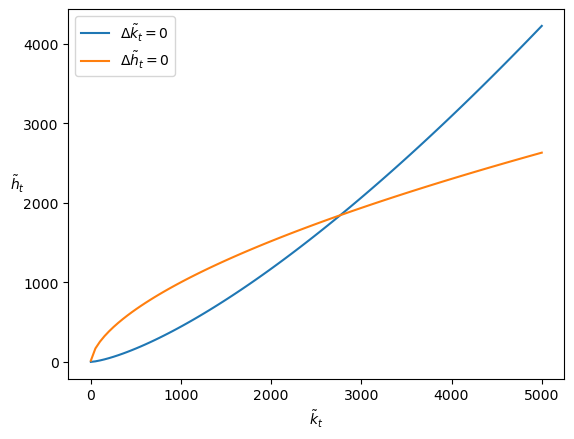

In [118]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(k_tilde_vec, null_k_val, label = r'$ \Delta \tilde{k}_t = 0$')
ax.plot(k_tilde_vec, null_h_val, label = r'$ \Delta \tilde{h}_t = 0$');
ax.set_xlabel(r'$\tilde{k}_t$',)
ax.set_ylabel(r'$\tilde{h}_t$', rotation = 0)

ax.legend(loc='upper left');

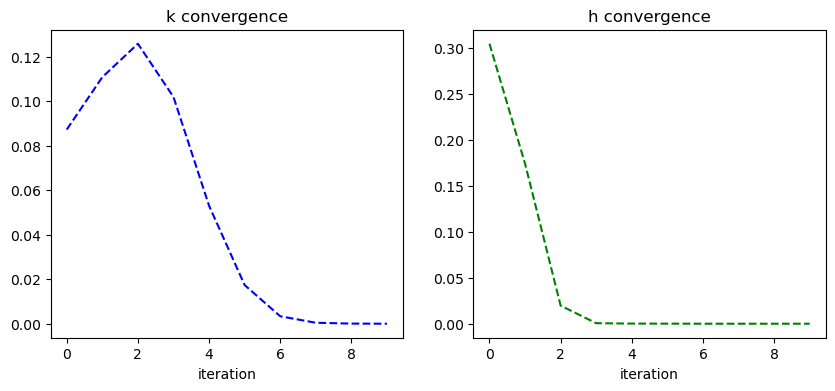

In [119]:

def steady_state(sK, sH, delta, g, n, alpha, sigma, evals=10):
    k, h = 0.5, 0.5
    fks = np.zeros(evals)
    fhs = np.zeros(evals)
    for i in range(evals):
        k_new = ((sK*h**sigma) + (1-delta)*k)**(1/(1-alpha))
        h_new = ((sH*k**alpha) + (1-g)*h)**(1/sigma)
        fks[i] = np.abs(k_new - k)
        fhs[i] = np.abs(h_new - h)
        k, h = k_new, h_new
        
    # Plot the convergences for k and h
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    i = evals-1
    axs[0].plot(np.arange(i+1), fks[:i+1], '--', ms=4, color='blue')
    axs[0].set_title("k convergence")
    axs[0].set_xlabel('iteration')
    axs[1].plot(np.arange(i+1), fhs[:i+1], '--', ms=4, color='green')
    axs[1].set_title("h convergence")
    axs[1].set_xlabel('iteration')
    plt.show()
    
    # Return the steady state values of physical and human capital
    return k, h

# Find the steady state values of physical and human capital
ss_k, ss_h = steady_state(0.1, 0.11, 0.05, 0.015, 0.01, 1/3, 1/3)


In [120]:
print(f'The steady state value for physical capital is {ss_k}')
print(f'The steady state value for human capital is {ss_h}')

The steady state value for physical capital is 1.3061039042689658e-05
The steady state value for human capital is 4.270500558315645e-08


# Extension of the model

In this part of the analysis, we analyse how the steady state values change when increasing the savings rate.

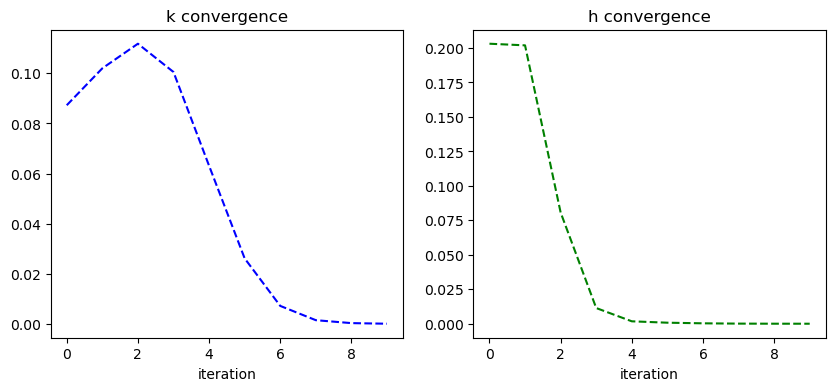

In [122]:
ss_k1, ss_h1 = steady_state(0.1, 0.22, 0.05, 0.015, 0.01, 1/3, 1/3)

In [125]:
print(f'The steady state value for physical capital is {ss_k1}')
print(f'The steady state value for human capital is {ss_h1}')

The steady state value for physical capital is 8.754011915600501e-05
The steady state value for human capital is 2.034613091011368e-06


# Conclusion

Add concise conclusion. 